In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, classification_report,
    precision_recall_curve
)
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv(r"C:\Users\dell\OneDrive\Desktop\bank churn\resources\analytical_base_table.csv")  # replace with actual data path
X = df.drop(columns=['Exited'])
y = df['Exited']

# Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Define columns
scale_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']


In [3]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), scale_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])


In [4]:
pipeline = ImbPipeline([
    ('preprocessor',preprocessor),
    ('model',xgb.XGBClassifier(
    scale_pos_weight=3.91,                 # for class imbalance
    eval_metric=['logloss', 'auc'],        # evaluate both metrics
    random_state=42
))]
)

In [5]:
param_grid = {
    'model__gamma': [0.3,0.5, 0.8],
    'model__max_depth': [2,3,5],
    'model__n_estimators': [25,50,100]
}

In [6]:
grid = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring = 'roc_auc',
    cv=5,n_jobs=-1,verbose=1
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)
print("Cross validation roc auc score" ,grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'model__gamma': 0.5, 'model__max_depth': 3, 'model__n_estimators': 50}
Cross validation roc auc score 0.8648192893091966


In [7]:
probs_val = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, probs_val)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid div-by-zero
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"Optimal Threshold (F1 max): {best_thresh:.4f}")


Optimal Threshold (F1 max): 0.6328


In [8]:
recall_cutoff = 0.75
valid_idxs = np.where(recall >= recall_cutoff)[0]

# Of those, pick the one with highest precision
best_idx_recall = valid_idxs[np.argmax(precision[valid_idxs])]
best_thresh_recall = thresholds[best_idx_recall]

print(f"Threshold for Recall ≥ 70%: {best_thresh_recall:.4f}")

Threshold for Recall ≥ 70%: 0.4975


In [9]:
probs_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test_recall = (probs_test >= best_thresh_recall).astype(int)

print(f"ROC-AUC on Test: {roc_auc_score(y_test, probs_test):.4f}")
print("Classification using Recall score threshold")
print(classification_report(y_test, y_pred_test_recall))

ROC-AUC on Test: 0.8639
Classification using Recall score threshold
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1593
           1       0.51      0.75      0.60       407

    accuracy                           0.80      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.80      0.81      2000



In [10]:
probs_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test = (probs_test >= best_thresh).astype(int)

print(f"ROC-AUC on Test: {roc_auc_score(y_test, probs_test):.4f}")
print(classification_report(y_test, y_pred_test))


ROC-AUC on Test: 0.8639
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1593
           1       0.60      0.63      0.62       407

    accuracy                           0.84      2000
   macro avg       0.75      0.76      0.76      2000
weighted avg       0.84      0.84      0.84      2000



In [11]:
from joblib import dump

model_package = {
    'model':best_model,
    'threshold':best_thresh_recall
}
dump(model_package,'../models/xgb_model.pkl')

['../models/xgb_model.pkl']

In [12]:
probs_train = best_model.predict_proba(X_train)[:, 1]
probs_val   = best_model.predict_proba(X_val)[:, 1]
probs_test  = best_model.predict_proba(X_test)[:, 1]


In [13]:
y_train_pred = (probs_train >= best_thresh_recall).astype(int)
y_val_pred   = (probs_val >= best_thresh_recall).astype(int)
y_test_pred  = (probs_test >= best_thresh_recall).astype(int)


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(y_true, y_pred, name):
    print(f"\n--- {name} ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))

evaluate(y_train, y_train_pred, "Train")
evaluate(y_val, y_val_pred, "Validation")
evaluate(y_test, y_test_pred, "Test")



--- Train ---
Accuracy : 0.82453125
Precision: 0.547061882475299
Recall   : 0.8067484662576687
F1 Score : 0.6519987604586303

--- Validation ---
Accuracy : 0.795
Precision: 0.49796747967479676
Recall   : 0.7515337423312883
F1 Score : 0.5990220048899756

--- Test ---
Accuracy : 0.8
Precision: 0.5057851239669422
Recall   : 0.7518427518427518
F1 Score : 0.6047430830039527


In [18]:
import matplotlib.pyplot as plt
# Extract trained XGBoost model
xgb_model = best_model.named_steps['model']



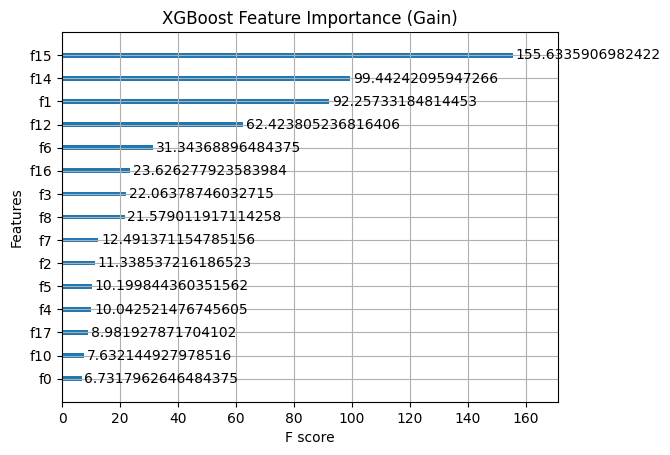

In [20]:
xgb.plot_importance(xgb_model, importance_type='gain')
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Step 1: Get preprocessor from pipeline
preprocessor = best_model.named_steps['preprocessor']

# Step 2: Extract column names after preprocessing
def get_feature_names(preprocessor):
    output_features = []

    for name, transformer, cols in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols  # if no get_feature_names_out
        output_features.extend(names)
    
    return output_features

feature_names = get_feature_names(preprocessor)

# Step 3: Pair feature names with importances
import pandas as pd

booster = xgb_model.get_booster()
importances = booster.get_score(importance_type='gain')

# Map to feature names
importance_df = pd.DataFrame({
    'Feature': [feature_names[int(k[1:])] if k[0] == 'f' else k for k in importances.keys()],
    'Gain': list(importances.values())
}).sort_values(by='Gain', ascending=False)

print(importance_df.head(10))


              Feature        Gain
12    NumOfProducts_2  155.633591
11    NumOfProducts_1   99.442421
1                 Age   92.257332
10   IsActiveMember_0   62.423805
6   Geography_Germany   31.343689
13    NumOfProducts_3   23.626278
3             Balance   22.063787
8       Gender_Female   21.579012
7     Geography_Spain   12.491371
2              Tenure   11.338537


| Rank | Feature             | Gain       | What It Means                                                                                                                                                             |
| ---- | ------------------- | ---------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1️⃣  | `NumOfProducts_2`   | **155.63** | Customers with exactly **2 products** are highly informative — likely to churn or stay based on something unique about this group. Investigate product bundling strategy. |
| 2️⃣  | `NumOfProducts_1`   | **99.44**  | Customers with only **1 product** tend to churn — they might not be deeply engaged. Upsell opportunities.                                                                 |
| 3️⃣  | `Age`               | **92.26**  | Older customers churn differently than younger ones. Possibly due to retirement, service dissatisfaction, or digital friction. Consider segmentation.                     |
| 4️⃣  | `IsActiveMember_0`  | **62.42**  | Inactive members (binary dummy = 0) are strong churn signals — very intuitive.                                                                                            |
| 5️⃣  | `Geography_Germany` | **31.34**  | German customers show a clear pattern — possibly more likely to churn. Check regional campaigns or service issues.                                                        |
| 6️⃣  | `NumOfProducts_3`   | **23.63**  | 3-product holders also matter. The relationship isn't strictly linear — perhaps 2 is more common and 3 is rare or risky.                                                  |
| 7️⃣  | `Balance`           | **22.06**  | Higher/lower balances might reflect wealth tiers — affecting loyalty differently. Could also correlate with credit risk.                                                  |
| 8️⃣  | `Gender_Female`     | **21.58**  | Female customers show a distinct churn behavior. Be cautious — interpret with fairness in mind.                                                                           |
| 9️⃣  | `Geography_Spain`   | **12.49**  | Spanish region less impactful than Germany but still matters. May reflect different branch policies or offers.                                                            |
| 🔟   | `Tenure`            | **11.33**  | Longevity in the bank has some but not strong impact — may affect churn depending on satisfaction or legacy offers.                                                       |


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


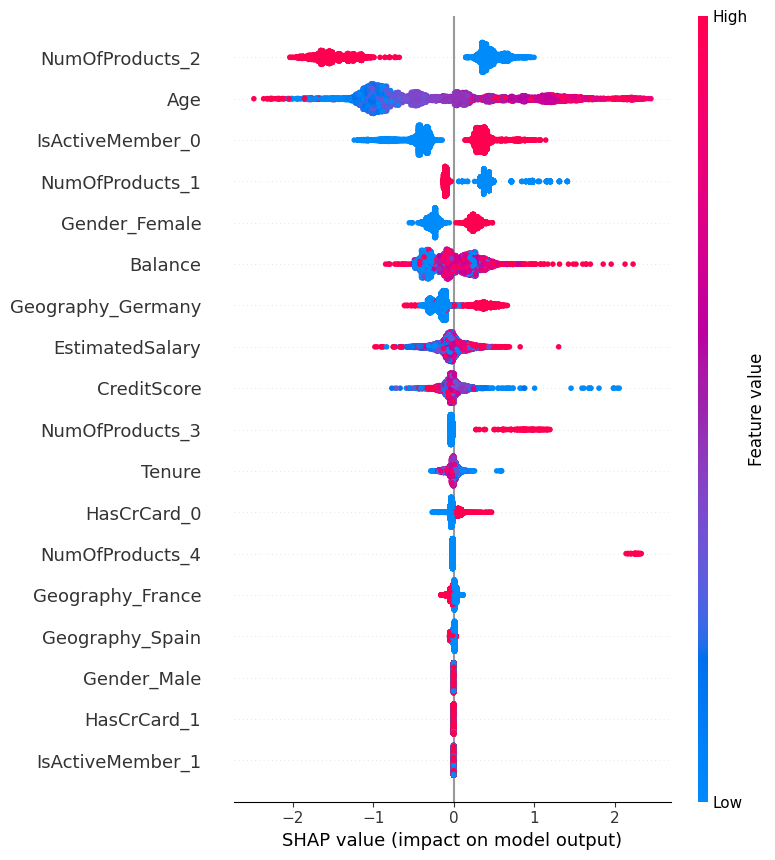

In [22]:
import shap

# Extract model and preprocessed data
xgb_model = best_model.named_steps['model']
X_transformed = best_model.named_steps['preprocessor'].transform(X_train)

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_transformed)

# SHAP summary plot
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)


In [ ]:
a